> #  Réduction de la dimension des données par PCA (Principal Components Analysis)

## Importation des modules nécessaires pour le travail

In [1]:
import cv2
import numpy as np
from tqdm import tqdm
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from matplotlib import offsetbox

## Récupération et stockage des fichiers

Pour le travail à réaliser, un dictionnaire sera créer afin de stocker le nom des classes, leurs images correspondantes, les images réduites par PCA et les composants PCA utilisés pour cette réduction.

In [4]:
### On importe les outils nécessaires à la récupéraion des images et du nom des classes
import os
import sys
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))

from lib import ressources as res
from lib import tools

racine = os.path.abspath(os.path.realpath(res.dir_root))

In [5]:
### Le nom des classes sont récupérés et stocké dans le dictionnaire sous la clé 'Classe'
classes=tools.listclasses(res.dir_dataset_train)
data={'Classe':[],'Listes_images':[]}
data['Classe']=classes

### Pour chaque classe, une liste d'images sous forme de tableau à 1 dimension est ajouté sous la clé 'Listes_images'
for i in range(len(classes)):
    liste_images=[]
    for path in tools.listdirectory(res.dir_dataset_train+os.sep+classes[i]):
        img=cv2.imread(path)
        img=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img=img.reshape(img.shape[0]*img.shape[1]*img.shape[2])
        liste_images.append(img)
    data['Listes_images'].append(np.array(liste_images))

## Réduction de la dimension des images par PCA

Lors de cette étape, nous allons opérer une réduction de dimension par PCA en indiquant une conservation de variance de 95%.

* Réalisation de la réduction de dimension

Initialisation de constances utilisées dans la suite du code

In [6]:
### Dimensions des photos
height=256
length=256
n_pixel=3

### Nombre de classe, implémenter 38 pour avoir la totalité des classes du dataset
n_classe=6

In [7]:
### Initiation de la méthode PCA, on conserve 95% de la variance
pca=PCA(0.95)

### Les images réduites vont être stockées dans le dictionnaire sous la clé 'Listes_images_pca'
### Les composants ayant servi à la réduction vont être sauvegardés sous la clé 'Components'
data['Listes_images_pca']=[]
data['Components']=[]

### La réduction de dimension est faite par classe
for liste_images in tqdm(data['Listes_images'][:n_classe]):
    liste_images_pca=pca.fit_transform(liste_images)
    data['Listes_images_pca'].append(liste_images_pca)
    data['Components'].append(pca.components_)

100%|██████████| 6/6 [28:58<00:00, 289.69s/it]


* Quantification de la PCA

Remarque: l'échelle des ordonnées est coupée pour une meilleure observation des différences entre classe.


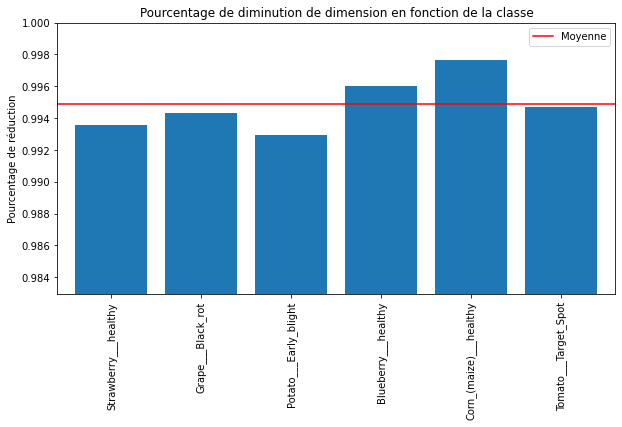

Pourcentage moyen de réduction de dimension : 99.486 % 

La méthode PCA a permis de diminuer grandement la dimension des données, avec un réduction de plus de 99% pour une perte de seulement 5% de la variance.


In [8]:
### Création d'une liste avec les pourcentages de diminution de dimensions obtenue par PCA pour chaque classe
n_components=np.array([])

for components in data['Components']:
    n_components=np.append(n_components,1-(len(components)/(height*length*n_pixel)))

range_classes=range(1,n_classe+1)    
moyenne=n_components.mean()

### On réalise un barplot pour observer la réduction de dimension selon les classes
### Un trait rouge vertical est ajouté pour déterminer la réduction moyenne
print("Remarque: l'échelle des ordonnées est coupée pour une meilleure observation des différences entre classe.")
plt.figure(figsize=(10,5))
plt.plot([0,n_classe+1],[moyenne,moyenne],color='red',label='Moyenne')
plt.bar(range_classes,n_components)
plt.xticks(range_classes,data['Classe'][:n_classe],rotation=90)
plt.ylabel('Pourcentage de réduction')
plt.title('Pourcentage de diminution de dimension en fonction de la classe')
plt.ylim(n_components.min()-0.01,1)
plt.xlim(0.4,n_classe+0.6)
plt.legend()
plt.show()

print('Pourcentage moyen de réduction de dimension :',np.round(moyenne*100,3),'%',"\n")
print("La méthode PCA a permis de diminuer grandement la dimension des données, avec un réduction de plus de 99% pour une perte de seulement 5% de la variance.")

## Affichage des données sur un graphique bi-dimensionnel

Pour afficher ces graphiques, nous allons prendre en compte les deux premiers composants des images réduites par PCA. Ils permettent souvent d'expliquer la majeure partie de la variance des données.
Nous allons visualiser la répartition des images par classe, en affichant certaines images pour avoir une meilleure compréhension de cette répartiton.

In [9]:
### Définition d'une fonction permettant de visualiser les données sur un graphique de projection bi-dimensionnel.
### Cette fonction permet d'afficher des images correspondant à certains points du graphique.
### Le paramètre thumb_frac permet de jouer sur la quantité d'images à afficher sur le graphique.
### Le paramètre zoom permet de changer la taille des images affichées.

def plot_components(data, images=None, ax=None,
                    thumb_frac=0.09,zoom=0.2):
    ax = ax or plt.gca()
    ax.plot(data[:, 0], data[:, 1], '.b')
    if images is not None:
        min_dist_2 = (thumb_frac * max(data.max(0)[:2] - data.min(0)[:2])) ** 2
        shown_images = np.array([2 * data.max(0)[:2]])
        for i in range(data.shape[0]):
            dist = np.sum((data[i,:2] - shown_images) ** 2, 1)
            if np.min(dist) < min_dist_2:
                # On ne montre pas le points trop proches
                continue
            shown_images = np.vstack([shown_images, data[i,:2]])
            imagebox = offsetbox.AnnotationBbox(
                offsetbox.OffsetImage(images[i],zoom=zoom),
                                      data[i,:2])
            ax.add_artist(imagebox)

L'observation de la dispersion des images nous donne certains informations sur le jeu de données. Certaines images ont été tournées pour augmenter les données. On observe que dans beaucoup de cas un classement se fait selon la 'luminosité' des photos. On remarque ainsi que certaines photos sont très surexposées et des photos sont segmentées avec la feuille seule sur un fond noir.


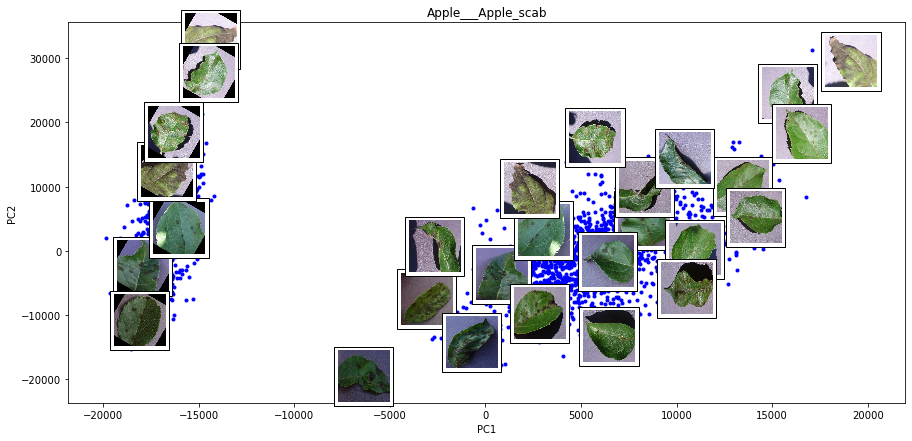

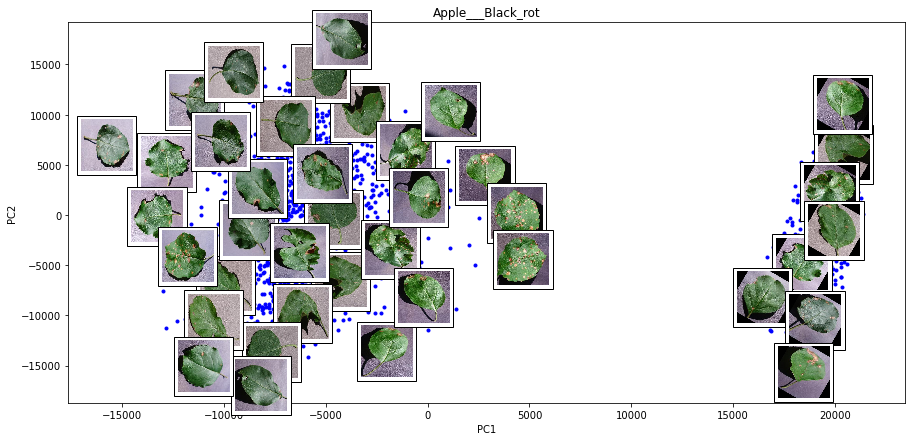

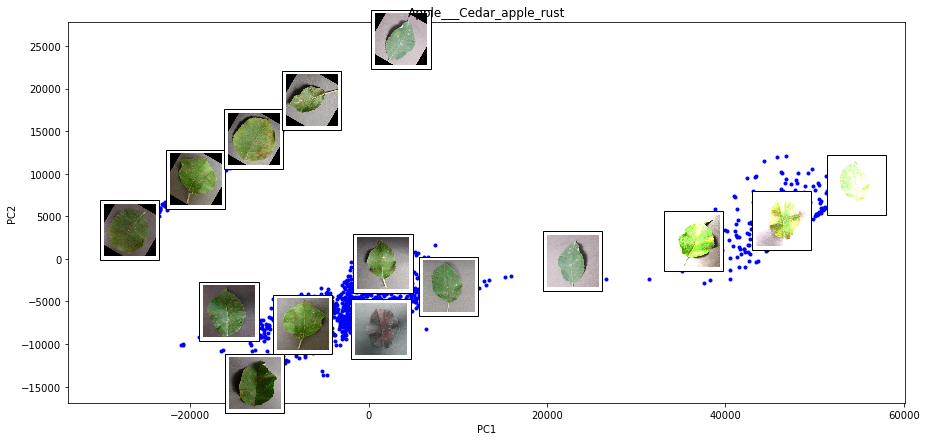

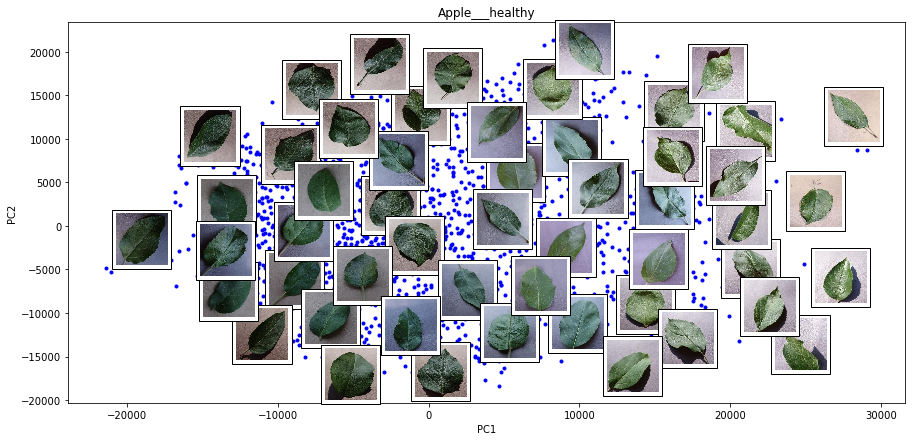

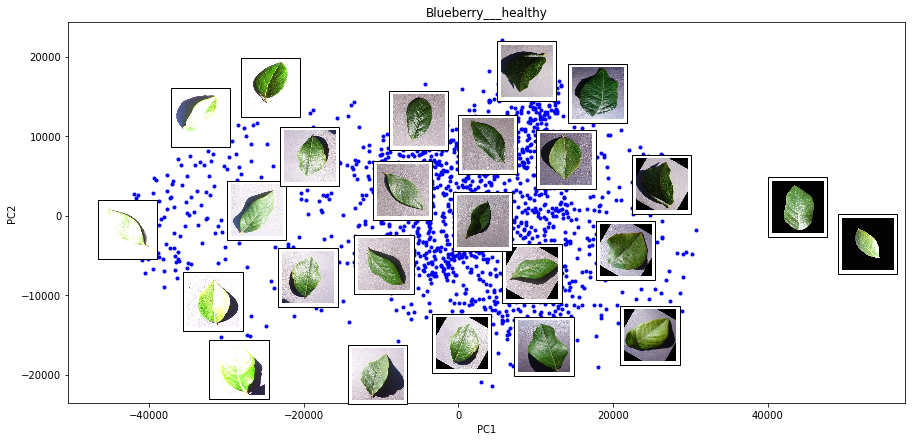

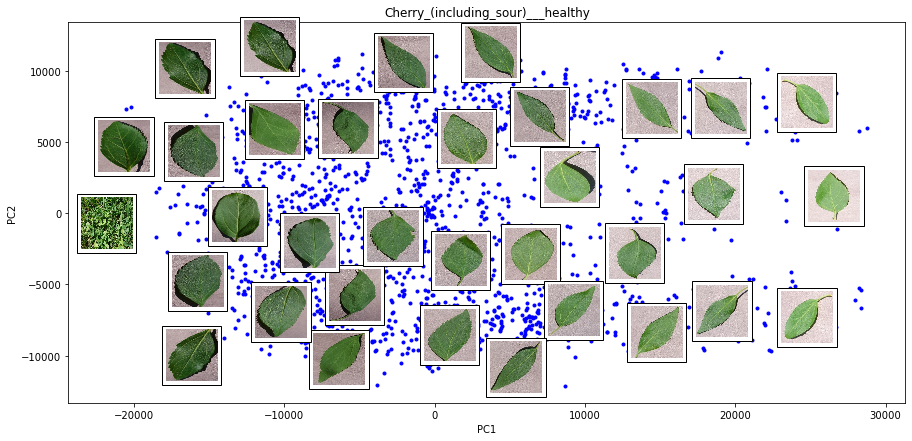

In [10]:
print("L'observation de la dispersion des images nous donne certains informations sur le jeu de données.", 
      "Certaines images ont été tournées pour augmenter les données." ,
      "On observe que dans beaucoup de cas un classement se fait selon la 'luminosité' des photos.", 
      "On remarque ainsi que certaines photos sont très surexposées et des photos sont segmentées avec la feuille seule sur un fond noir.")

### Affichage des graphiques par classe

for liste_images_pca, liste_images, name in zip (data['Listes_images_pca'],data['Listes_images'][:n_classe],data['Classe']):
    ### Redimensionnement des images pour leur affichage
    images=[]
    for image in liste_images:
        image=image.reshape(height,length,n_pixel)
        images.append(image)
    ### Définition des graphiques
    plt.figure(figsize=(15,7))
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.title(name)
    plot_components(liste_images_pca,images)